In [2]:
import os # This library will help us in defining paths, when we have to save our modeling materials. 
import cv2 # This is the OpenCv library, which is used for Computer Vision, ML and Image Processing.
import glob # We are going to use this library in defining the path in a loop.
import urllib.request # This library will help us with downloading the training and testing images .
import pandas as pd # This library we will use to put our data in a data frame 
import numpy as np # This library will help us with calculating multi-dimensional arrays and matrices.
import googletrans # This library will allow us to translate this library in Enligsh
from googletrans import Translator # This specific function will do the translation.
import matplotlib.pyplot as plt # With this library we are going to visualize our data. 
import pickle # This library will save and store our model after creating it.And latter using it on different data set, whenever we want.
from scipy import ndimage as nd #From this library we import a couple of filters, which are going to help us in the feature engenering.
from scipy.ndimage.filters import convolve # This stores our convolutions.
from skimage.filters import roberts, sobel, scharr, prewitt #From this library we import a couple of filters, which are going to help us in the feature engenering.
from skimage.io import imread # We can read images from that function. 
from sklearn.model_selection import train_test_split # This model will help us, to split our data set to training and testing in the creation of our Traditional Machine Learning Model, which we are going to use for Image Segmentation, and latter will help us for Image Classification.
from sklearn.ensemble import RandomForestClassifier # We are loading the estimator, which will help us in our modeling.
from sklearn import metrics # The metrics will help us to see if our model is accurate enough in the testing. Then, we will used it to extract only the result wich are closer enough to our testing.Thus we will know we are selecting only the samples with similar features.
from datetime import datetime # This library will format our date column, so we can use it latter in timeline visualizations.

In [ ]:
introduction = "" # This is an empty variable, which we are going to fill with our Introduction.
with open("text/Intro.txt", "r", encoding = "utf-8") as file: #The load file is loaded 
    introduction = file.read() # The variable reads the text. 
print(introduction) #Lets see it: 

# Data Cleaning:

The Rijksmuseum has a public datadase, which is open to the audince and everyone can accsess it. Their website offers different ways of accessing the collection data, such as downloads and APIs : https://www.rijksmuseum.nl/en/data. If you want to use the data from their public APIs, you will need to have the key, which is easy to aquire, just follow the steps on their page. The way I am going to read the collection data is with their .csv file. You can download it from : https://scan.rijkskoha.nl/adlibdumps/201911-rma-csv-collection.zip, and store it in the data folder.

In [ ]:
collection_nl = pd.read_csv('data/201911-rma-csv-collection.csv') # Here we load the data set
collection_nl.head(5) #Let's see what we have done so far. Here we notice the language is Dutch, this is the reason we saved the variable for it with a description "_nl".

In [ ]:
collection_nl.columns = ['id', 'pi', 'title', 'type', 'creator', 'creation_date', 'image'] #Now we rename the columns for more clean vision
collection_nl.head(5) #Lets see if the columns has been changed properly.

In [ ]:
collection_nl.shape # Now we will inspect our data frame for its dimensions.

In [ ]:
collection_nl.dtypes # Here we will notice if the separate columns are encoded in their needed format for further modeling.

In [ ]:
# Let's inspect for NaN values in a random column (with the help of a function):
def get_unknown_date(collection_nl):
    """
    Returns every record, which have a unknown date.Thus we can see if 
    every collection object have identified year of production. This is vital as we will use the origin of the
    objects in our visualization, and if there is a row without a date, we need to get rid of it.
    """

    unknown_date = collection_nl[collection_nl["creation_date"].isnull()]
    return unknown_date

In [ ]:
objects_with_unknown_date = get_unknown_date(collection_nl)
print(objects_with_unknown_date) # After runing the cell we see there is 23322 rows with a NaN values.

In [ ]:
collection_nl = collection_nl.dropna() # This will remove every NaN value in our dataframe.

In [ ]:
collection_nl.shape #Now we see now the total number of rows is 372441, which means there were null values not only in the Date column but in others as well.

In [ ]:
def unknown_artists(collection_nl): # Now we will clean the data from the anonymous authors, as we have need from the author names for more correct analyze.
    """
    Returns the rows, which have not registrated and identified author.
    """
    anonymous = collection_nl[collection_nl.creator == 'anonymous'] #Here we search for artists "anonymous" as this is the word with which they have been indicated in the previous print.
    return anonymous

In [ ]:
anonymous = unknown_artists(collection_nl)
print(anonymous) # Here we notice that 89087 observations have not even a identified painter. 

In [ ]:
collection_nl = collection_nl[~collection_nl['creator'].isin(['anonymous'])] # Here we are getting rid of every work without a indified creato.

In [ ]:
collection_nl.shape # Now check if the observeations are the right number (372441−89087=283354) => Everything seems perfect.

Now we are ready to translate our dataframe. Here note that we will translate only the types of object. This is because later in our EDA we are going to cotrast different objects, years, and number of works from the whole collection. e.g. for this task we will do not have need from the names or the titles. If we translate everything right now there is a huge probability our program to crash, because of the multi-tasking with almost 300k records.
However, we are going to translate the titles of works later when we filter our whole dataset only to the 17th century. This will be needed for a particular task, but not now. 

In [ ]:
# Now we can continue with the translation of the types column.
collection_types = collection_nl.copy() # First, we copy the dataframe in a new variable, which indicates it will be the English version.

In [ ]:
translator = Translator() #Here we create a variable, which stores the function from the library googletrans

In [ ]:
translations = {} # This is an empty variable, which will store our translated words
unique_elements = collection_types.type.unique() # This will find every different type of work. 
for element in unique_elements: # This loop is about to translate every foreign word in our "unique_elements" variable
       """
       This will translate every unfamiliar element in the column 'type', then it will store the translations in the
       variable.
       """
        # add translation to the dictionary
        translations[element] = translator.translate(element).text
    
print(translations) #This could take some time. So be prepared to wait a litle bit.

In [ ]:
# Now we need to applying it to the dataframe:
collection_types.replace(translations, inplace = True)

In [ ]:
print(collection_types.type.unique()) # Lets inspect if everything has been translated correctly: 

In [ ]:
collection_types.to_csv('data/collection_types', index = False) # We save the cleaned and translated dataframe in a new(separated) file, so it will be easier to read it, instead to run the whole process again(and wait the translator every single time as we already see it needs a bit of a time to process.)

Now we are will continue to clean the new file and extract from it, this time - a concrate information only about paintings, produced through 17th century. This is needed because as we said and see in the  begining of the project our goal is not only to clean the collection data set and analyze it, but to construct and prove hypothesis around Rembrand's painting, as well. So, we are going to produce now a new cleaned dataframe and store it again in a new file.

In [ ]:
collection_17 = pd.read_csv('collection_types')

In [ ]:
collection_17.shape # Lets see if we have read the correct file. 

In [ ]:
collection_17.dtypes # Lets inspect the type of the data, as this time it is crucial for future filtering of particular information.

In [ ]:
collection_17.creation_date = pd.to_numeric(collection_17.creation_date, errors = "coerce")

In [ ]:
collection_17.dtypes # Now we see we have float instead of object, for our choosen column.

In [ ]:
collection_17 = collection_17.dropna() # We need to run this comand again before changing the date type as we have new null values, which the next cell cannot read.

In [ ]:
collection_17["creation_date"] = collection_17["creation_date"].astype(float).astype(int)

In [ ]:
collection_17.dtypes # Everything is perfect, now we will extract only those observations, which have values between 1600-1700 in their date colum.

In [ ]:
# To do so, we will create a function, which will return the names of artist from the wanted period.
def searching_seventeenth_century_artists(dataframe):
    """
    Returns only the names of creators, who has created something in 17th century.
    """
    artist = collection_17[(collection_17.creation_date > 1600) & (collection_17.creation_date < 1700)][["creator"]]
    return artist

In [ ]:
artists = searching_seventeenth_century_artists(collection_17) # This variable will call the function, created above.
print(artists) # This will print the names. 

In [ ]:
# To make this list part of our dataframe we will drop the "creator" column and replace it with the new one "artist"
collection_17 = collection_17.drop(columns = ['creator'])

In [ ]:
collection_17['artist'] = artists #The new column have only our filter, thus in other ones we have a lot of NaN values. 

In [ ]:
collection_17 = collection_17.dropna() #For that reason we wil clean our dataframe from the new apeared null values.

In [ ]:
collection_17.shape # The number of observations is the same as the new 'artist' column, so everyting done so far is correct.

In [ ]:
def searching_seventeenth_century_paintings(dataframe): # This time the function will print only titles of object that are paintings by their type.
    """
    Returns the title of every painting, produced in 17th century.
    """
    artwork = collection_17[collection_17.type == 'painting'][["title"]] #Here we search for type objects "paintings".
    return artwork 

In [ ]:
artworks = searching_seventeenth_century_paintings(collection_17) # Now we have only observations of paintings, which are 1820(through 17th century). 
print(artworks) # However, let's not forget this variable is not a part of our dataframe yet.

In [ ]:
collection_17 = collection_17.drop(columns = ['type']) # This time we will drop the column for types as well. This is because now we have only paintings.
collection_17 = collection_17.drop(columns = ['title']) # The new list of artworks will be added to the dataframe, so we will have no need from the previous "title"

In [ ]:
collection_17['title'] = artworks # Do not forget that the new fillter is applied only to this column and after it we will have a lot of NaN values in the other columns.

In [ ]:
collection_17 = collection_17.dropna() #For that reason we will clean it again from null values

In [ ]:
# Now we will chek if everything is "OK", before continuing to the translation.
collection_17.shape #Everything, is cleaned correctly as we extracted only 1830 observations out of 283354.

In [ ]:
collection_17.head(5) #Lets see if everything is connected properly. 

In [ ]:
#Everything seems fine, apart of that our column could be replaced for more logical vision as now we have the title and the author at the end of the frame.
column_names = ["id", "artist", "title","creation_date", 'image', 'pi'] # This variable stores a logic formulation of our columns.
collection_17 = collection_17.reindex(columns=column_names) # This will apply the variable to our original data frame and change it.
collection_17.head(5) # Now everything must be perfect.

Now we are ready to translate our dataframe. Here note that we will translate only the titles as the names of the authors stands the same every time we read for their masterpecies even if it is in English leanguage.
Another reason not to translate the column with names is that the translator will transform "van" to "from", which only will make the whole information incorrect.

In [ ]:
# Now we can continue with the translation of the dataframe.
seventeenth_century_paintings = collection_17.copy() # First, we copy the dataframe in a new variable, which indicates it w

In [ ]:
translations1 = {} # This is an empty variable, which will store our translated words.
unique_elements1 = seventeenth_century_paintings.title.unique() # This will find every different title. 
for element in unique_elements1: # This loop is about to translate every foreign word in our "unique_elements" variable
        # add translation to the dictionary
        translations1[element] = translator.translate(element).text
    
print(translations1) #This could take some time. So be prepared to wait a litle bit.

In [ ]:
# Now we need to applying it to the dataframe:
seventeenth_century_paintings.replace(translations1, inplace = True)

In [ ]:
#Lets inspect if everything is correct:
seventeenth_century_paintings.title.unique() #Everythin looks translated correcly.

In [ ]:
seventeenth_century_paintings.to_csv('data/seventeenth_century_paintings', index = False) # We save the cleaned dataframe in a new(separated) file, so it will be easier to read it, instead to run the whole process again(and wait the translator every single time.)

# EDA Analysis and Data Visualization: 

In this section we are going to separate our data set by a couple of fators, and form simple outcomes. In the first part will be included all the records. Next in the second part of this section will be used only the data frame, which includes the record only for paintings produced through 17th century. In this part will be approved or declined our First Hypothesis which is illustrated here :

Our hypothesis will be examined after we separate every picture through 17th century(the century in which Remrandt has produced Night Watch, the painting which is exhibited centraly in the “Night Watch Room”) into a different category. The grouping in categories will be done by the numbers of works produced by a single painter through this period. Basically, we will explore the theory that a curator in a particular museum is trying to aquire or keep more paintings related or produced by a native painter. Next, from the visualization we will conclude if in the Rijkmuseum, the dutch painters though 17th century have succeded to attract the attention of the curator. 

In [ ]:
#First of all, we will set our style for graphics, that will be produced later. 
plt.style.use('fivethirtyeight') #This style is choosen, becuase of three major reasons: 
#1. Its clearness.
#2. The added lines in the background, which could be used for easier navigation. 
#3. The different major colors, which could be not mistaken. 

In [ ]:
seventeenth_century = pd.read_csv('data/seventeenth_century_paintings') # Loading the filtered data frame for 17th centuries paintings. 
whole_collection = pd.read_csv('data/collection_types') # Loading the whole collection.

In [ ]:
whole_collection.head(5) # Lets inspect the data frame : 

In [ ]:
def get_number_of_works(dataframe):
    """
    Returns the summed number of creators. It means if we have someone who has created 30 paintings and have 
    30 different observations in the dataframe, the function will add it to one. Thus will be done grouping by
    the same authors names and it will count the final result. 
    """
    groups = dataframe.groupby("creator").count()
    
    return groups

In [ ]:
numbers = get_number_of_works(whole_collection) # This varaibale will get the function above. 
print(numbers) # We see there are 18128 individual artist registered in the collection .

In [ ]:
numbers.id.unique() # Lets see the unique number and which is the biggest or smallest number of produced works by a single author.

In [ ]:
def get_num_category(dataframe):
    """
    Returns the separation between the number of produced works by a single author in 
    three different groups .
    """
    few, average, many = (0, 0, 0) #those are the different categories .
    few = len(dataframe[dataframe.id <= 1000]) #this is for the authors with less than 10 works.
    average = len(dataframe[(dataframe.id > 1000) & (dataframe.id <= 2000)]) #this is for the authors with more than 10 and less than 20 works.
    many = len(dataframe[dataframe.id > 2000]) #this is for the authors with more than 20 works.
    return few, average, many

In [ ]:
few, average, many = get_num_category(numbers) # Those variables will get and store the results from the function.

In [ ]:
plt.figure()
plt.figure(figsize=(15,10))# Here we create a figure, which will be used for subploting. 
plt.subplot(121) #This is our first figure, which shows the category and the numbers of our result. 
plt.bar(range(3), [few, average, many]) # we will construct a bar chart with those three variables for every category.
plt.title('All artists by the category of works produced:')
plt.xticks(range(3), ["few", "average", "many"])
plt.ylabel("Artists")

plt.subplot(122) #This is our second figure, which shows only the categories about painters with more than 1000 works.
plt.bar(range(2), [average, many]) # we will construct a bar chart with only the two smallest category, so we can see them clear. 
plt.title('Artists with more than 2000 objects : ')
plt.xticks(range(2), ["average", "many"])
plt.ylabel("Artists")
plt.savefig('graphs/number_of_works_produced_by_categories')
plt.show()

In [ ]:
numbers = numbers.reset_index() # Lets reindex our variable which shore the previous result, so we can used it for a further filtering.

In [ ]:
def search_artists_names(dataframe):
    """
    Returns only the names of artists, who have produced more than 2000 works
    """
    
    artists_with_many_works = dataframe[(dataframe.id > 2000)][["creator"]]
    return artists_with_many_works

In [ ]:
names = search_artists_names(numbers) # This variable will store the names resulted in the function above. 
print(names) # We see we have only 6 authors with more than 2000 works produced. Those are the collection's most productive creators:

In [ ]:
def get_number_of_works_by_type(dataframe):
    """
    Returns a data frame with grouped types and calculated their overall including in the data frame .
    """
    types = dataframe.groupby("type").count()
    return types

In [ ]:
Marius = whole_collection[whole_collection['creator'].str.contains(r'Bauer(?!$)')] # This find every work by the choosen author.
types = get_number_of_works_by_type(Marius) # This group every different types of works, so we can see the overall number of particular works.
types = types.reset_index() # This reindex the table, so we can used it later for visualizing. 
print(types) # Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
George_Hendrik = whole_collection[whole_collection['creator'].str.contains(r'Breitner(?!$)')] # This find every work by the choosen author.
types1 = get_number_of_works_by_type(George_Hendrik)# This group every different types of works, so we can see the overall number of particular works.
types1 = types1.reset_index()  # This reindex the table, so we can used it later for visualizing.
print(types1) # Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
Daniel_Nikolaus = whole_collection[whole_collection['creator'].str.contains(r'Chodowiecki(?!$)')] # This find every work by the choosen author.
types2 = get_number_of_works_by_type(Daniel_Nikolaus)# This group every different types of works, so we can see the overall number of particular works.
types2 = types2.reset_index()  # This reindex the table, so we can used it later for visualizing.
print(types2) # Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
Isaac = whole_collection[whole_collection['creator'].str.contains(r'Israels(?!$)')] # This find every work by the choosen author.
types3 = get_number_of_works_by_type(Isaac)# This group every different types of works, so we can see the overall number of particular works.
types3 = types3.reset_index()  # This reindex the table, so we can used it later for visualizing.
print(types3) # Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
Jan = whole_collection[whole_collection['creator'].str.contains(r'Luyken(?!$)')] # This find every work by the choosen author.
types4 = get_number_of_works_by_type(Jan)# This group every different types of works, so we can see the overall number of particular works.
types4 = types4.reset_index()  # This reindex the table, so we can used it later for visualizing.
print(types4)# Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
Reinier = whole_collection[whole_collection['creator'].str.contains(r'Vinkeles(?!$)')] # This find every work by the choosen author.
types5 = get_number_of_works_by_type(Reinier)# This group every different types of works, so we can see the overall number of particular works.
types5 = types5.reset_index()  # This reindex the table, so we can used it later for visualizing.
print(types5) # Lets see in how much different types of works, the author have produced and how much are they for every different type: 

In [ ]:
plt.barh(types.type, types.id, color='aqua', label='Marius') 
plt.barh(types1.type, types1.id, color='chartreuse', label='George Hendrik')
plt.barh(types2.type, types2.id, color='blue', label='Daniel Nikolaus')
plt.barh(types3.type, types3.id, color='red', label='Isaac')
plt.barh(types4.type, types4.id, color='yellow', label='Jan')
plt.barh(types5.type, types5.id, color='purple', label='Reinier')
plt.title('Most productive painters in the collection:')
plt.ylabel("Type of works")
plt.xlabel("Number of works")
plt.legend(loc='upper center', bbox_to_anchor=(1, 0.9), shadow=True, ncol=1, fontsize= 10)
plt.savefig('graphs/6_most_productive_painters')
plt.show()

From this bar chart(horizontal), we see clearly two things. First of all, who are the most productive authors in the whole collection. Then, which are the most choosen type for their works in the collection. We can conclude the sketchbook sheets and pictures are among the most numerous objects in the collection of the museum.

In [ ]:
all_types = get_number_of_works_by_type(whole_collection) # Now we will use the previous function, this time we will apply it to the whole collection.
all_types = all_types.reset_index()  # Here we reindex the result.
print(all_types) # And we see we have 910 different types of works .

In [ ]:
all_types.id.nlargest(10) # Those are 10 types, which are the most used in the collection. 

In [ ]:
def get_most_well_known_types_of_objects(dataframe):
    """
    Returns top ten type of works by their number of works in the collection.
    """
    top_ten = (dataframe[dataframe.id >= 1123])[["type"]]
    return top_ten

In [ ]:
top = get_most_well_known_types_of_objects(all_types) # This variable will get and store the function above. 
print(top) # Now we are ready to create a function, which will help us to plot them. 

In [ ]:
all_types['type'] = top # Here we are replacing the type column in our first dataframe, with the new result about only 10 types.

In [ ]:
all_types = all_types.dropna() # We need to drop NaN values , as there will be probably around 900 observations without a specified type in the newly added column.

In [ ]:
all_types.sort_values("id", axis = 0, ascending = True, 
                 inplace = True) # Lets sort the values for more correct viewing. 

In [ ]:
all_types.head(10) # Lets see which are most viewed types of works in the collection:

In [ ]:
plt.figure(figsize=(15,10))
plt.barh(all_types.type, all_types.id, color='purple')
plt.title('Classification among top ten most used mediums:')
plt.ylabel("Type of works")
plt.xlabel("Number of works")
plt.savefig('graphs/top_ten_most_used_mediums')
plt.show()

From this visualization we can again conclude two things. First, the pictures are the most common object in the collection . Second, After the painting (other types of works by amount) are very specific types and have a little number of produced works. For that, reason next we are going to inspect the 7 most produced types by their year of production. Thus, we can spot when and how much a particular type of work has been in its peak and also if there is a simillar patterns in the timeline of two different types of works. Please note that, we will exclude the "picture" type for the reason it has very different number of works in it. So, I will inspect it individually and separatelly with more correct visualization as we will have to spot almost 6 times more objects. 

In [ ]:
whole_collection['creation_date'] = pd.to_datetime(whole_collection['creation_date'], errors='coerce') # Here we are applying a format onto our data column. 

In [ ]:
whole_collection['year'] = whole_collection['creation_date'].dt.year # As our column includes different observetions we will create a new column, which will store only the years.

In [ ]:
whole_collection = whole_collection.dropna() # As we will inspect only the observations with specified year, we will drop the other results. 

In [ ]:
whole_collection["year"] = whole_collection["year"].astype(int) # Changing the type of the column to integer, as it was a float. 

In [ ]:
def get_production_per_year(dataframe):
    """
    Returns the amount of produced works in a particular year. This means it combines the rows where a year is 
    dublicated, thus it sums the overall number of works during the year. 
    """
    amount = dataframe.groupby("year").count()
    return amount

In [ ]:
def finding_all_drawings(dataframe):
    """
    Returns all drawings by type in the collection.
    """
    drawings = dataframe[(dataframe.type == 'drawing')]
    return drawings

In [ ]:
all_drawings = finding_all_drawings(whole_collection) # This will find all drawing in the collection.
print(all_drawings) # We have 20445 drawings .

In [ ]:
production_drawings = get_production_per_year(all_drawings) # Here we will combine the records, which have been produced in a particular year .
production_drawings = production_drawings.reset_index() # Lets reindex the resulted dataframe.  
print(production_drawings) # We can see we have only 284 unique years in which drawings have been produced .

In [ ]:
# Lets do the same with other types of works : 
def finding_all_photos(dataframe):
    """
    Returns all photos by type in the collection.
    """
    
    photos = dataframe[(dataframe.type == 'photo')]
    return photos

In [ ]:
all_photos = finding_all_photos(whole_collection)# This will find all photos in the collection.
print(all_photos)# We have 26713 drawings .

In [ ]:
production_photos = get_production_per_year(all_photos)#  Here we will combine the records, which have been produced in a particular year 
production_photos = production_photos.reset_index() # Lets reindex the resulted dataframe. 
print(production_photos)# We can see we have only 126 unique years in which photos have been produced .

In [ ]:
def finding_all_sketchbooks(dataframe):
    """
    Returns all sketchbooks by type in the collection.
    """
    
    sketchbooks = dataframe[(dataframe.type == 'sketchbook sheet')]
    return sketchbooks

In [ ]:
all_sketchbooks = finding_all_sketchbooks(whole_collection) # This will find all sketchbooks in the collection.
print(all_sketchbooks)# We have 26111 sketchbooks .

In [ ]:
production_sketchbooks = get_production_per_year(all_sketchbooks) #  Here we will combine the records, which have been produced in a particular year .
production_sketchbooks = production_sketchbooks.reset_index() # Lets reindex the resulted dataframe. 
print(production_sketchbooks)# We can see we have only 139 unique years in which sketchbooks have been produced 

In [ ]:
def finding_all_ph_prints(dataframe):
    """
    Returns all prints by type in the collection.
    """
    
    ph_prints = dataframe[(dataframe.type == 'photomechanical print')]
    return ph_prints

In [ ]:
all_ph_prints = finding_all_ph_prints(whole_collection) # This will find all prints in the collection.
print(all_ph_prints) # We have 7838 prints .

In [ ]:
production_ph_prints = get_production_per_year(all_ph_prints) #  Here we will combine the records, which have been produced in a particular year .
production_ph_prints = production_ph_prints.reset_index() # Lets reindex the resulted dataframe. 
print(production_ph_prints) # We can see we have only 69 unique years in which prints have been produced .

In [ ]:
def finding_all_stereofotos(dataframe):
    """
    Returns all stereofotos by type in the collection. 
    """
    
    stereofotos = dataframe[(dataframe.type == 'stereofoto')]
    return stereofotos

In [ ]:
all_stereofotos = finding_all_stereofotos(whole_collection) # This will find all stereofotos in the collection.
print(all_stereofotos) # We have 5129 stereofotos .

In [ ]:
production_stereofotos = get_production_per_year(all_stereofotos) #  Here we will combine the records, which have been produced in a particular year .
production_stereofotos = production_stereofotos.reset_index() # Lets reindex the resulted dataframe. 
print(production_stereofotos) # We can see we have only 74 unique years in which stereofotos have been produced .

In [ ]:
def finding_all_paintings(dataframe):
    """
    Returns all paintings by type in the collection.
    """
    
    paintings = dataframe[(dataframe.type == 'painting')]
    return paintings

In [ ]:
all_paintings = finding_all_paintings(whole_collection) # This will find all paintings in the collection.
print(all_paintings) # We have 1936 drawings .

In [ ]:
production_paintings = get_production_per_year(all_paintings) #  Here we will combine the records, which have been produced in a particular year .
production_paintings = production_paintings.reset_index() # Lets reindex the resulted dataframe. 
print(production_paintings) # We can see we have only 242 unique years in which paintings have been produced .

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(production_drawings.year, production_drawings.id, label='drawings')
plt.plot(production_photos.year, production_photos.id, label='photos')
plt.plot(production_sketchbooks.year, production_sketchbooks.id, label='sketchbooks')
plt.plot(production_ph_prints.year, production_ph_prints.id, label='photomechanical prints')
plt.plot(production_stereofotos.year, production_stereofotos.id, label='stereofotos')
plt.plot(production_paintings.year, production_paintings.id, label='paintings')
plt.title('The Production of top 7 types of works, through the years:', fontsize=30)
plt.suptitle('(without paintings)', fontsize=20)
plt.ylabel("Number of production", fontsize=20)
plt.xlabel("Year", fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1, fontsize= 20)
plt.savefig('graphs/the_production_through_years')

plt.show()

From this visualization, we can conclude three things. First of all, most evident one is that almost all types have their peak in 19th century. Maybe there is a reason for that or the curator of the museum have particular idea behind collecting objects from this period ? (We need to research further.) Then, we can spot that the drawing are the ones with a little bit different timeline, as they have been most produced in the second half of 18th century. And finally, we can see that the paintings have been produced in the whole time in the same proportion. They are the most stable one type of work. 

In [ ]:
# Lets inspect the pictures separately: 
def finding_all_pictures(dataframe):
    """
    Returns all pictures by type in the collection.
    """
    
    pictures = dataframe[(dataframe.type == 'picture')]
    return pictures

In [ ]:
all_pictures = finding_all_pictures(whole_collection) # This will find all pictures in the collection.
print(all_pictures) # We have 92649 drawings .

In [ ]:
production_pictures = get_production_per_year(all_pictures)#  Here we will combine the records, which have been produced in a particular year .
production_pictures = production_pictures.reset_index() # Lets reindex the resulted dataframe.  
print(production_pictures) # We can see we have almost 300 unique years in which pictures have been produced .

In [ ]:
#Lets visualize the result 
plt.figure(figsize=(15,10))
plt.scatter(production_pictures.year, production_pictures.id, label = 'Picture')
plt.title('The Production of pictures through the years', fontsize=30)
plt.ylabel("Number of production", fontsize=30)
plt.xlabel("Year", fontsize=30)
plt.legend(fontsize= 30)
plt.savefig('graphs/the_production_of_pictures_through_years')
plt.show()

It is clear that the pictures have been produced very chaotic. This means their production have been never structured till the begining of 20s century. There their production becomes not only more structured, but they begins to disappear as a type. 

In [ ]:
seventeenth_century.head(5) # Lets inspect our next dataframe: 

In [ ]:
def finding_dutch_origins(dataframe):
    """
    Returns natives and foreigns people by their name origin.
    """
    natives, non_natives = (0, 0)
    natives = dataframe[dataframe['artist'].str.contains(r'van(?!$)')]
    non_natives = dataframe[~(dataframe['artist'].str.contains(r'van(?!$)'))]
    return natives, non_natives

In [ ]:
natives, non_natives = finding_dutch_origins(seventeenth_century)

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(natives.creation_date, color ='b', label = 'natives')
plt.hist(non_natives.creation_date, color ='r', label = 'non-natives')
plt.title('A comparison in the number of natives or foreigners through 17th century:', fontsize=30)
plt.legend(loc='upper center', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1,fontsize= 30)
plt.savefig('graphs/natives_vs_non_natives')
plt.show()

Here we clearly can see that through the 17th century, there are a lot more foreign artist in the collection. However, we can determine the affection by the natives onto the curator. And this graph is here for a reason, to see how we need to use a different approach, and try to think logicali, instead only to write some lines of code. This comparison is inapropriate, because it is the same to compare the population of Netherlands with the rest of the world. Instead, we are going to see first to which author has been paid more attention and have aquired more than one or more works in the collection. Thus, we are going to categorize our painters during the period in respect of how much works they have in the collection, and then we will see if they are all not only with Dutch origins, but have been born in the Netherlands.  

In [ ]:
# In this frame every row represent different artwork. However, to do our EDA and prove our first hypothesis, we need to know the exact number of artist. 
# This means to count every artwork produced from the same author and sum the numbers. This we will do with by grouping.
def get_number_of_works(dataframe):
    """
    Returns the number of works produced by a single artist.
    """
    groups = dataframe.groupby("artist").count()
    return groups

In [ ]:
numbers = get_number_of_works(seventeenth_century)
print(numbers)

In [ ]:
# It looks like that fthe 1820 paintings in the whole collection of Rijksmuseum, were produced only by 601 painters .
numbers.id.unique() # On one hand there are painters with only one artwork, while on the other it seems someone has painted more than 30 paintings. 

In [ ]:
numbers.id.dtypes # We need to be sure our data type is 'int', because in the next step we will create a function, which will separate our painters in three different categories .

In [ ]:
def get_num_category(dataframe):
    """
    Returns, three separated categories by the productivity of the painter .
    """
    few, average, many = (0, 0, 0) #those are the different categories .
    few = len(dataframe[dataframe.id <= 10]) #this is for the painters with less than 10 paintings.
    average = len(dataframe[(dataframe.id > 10) & (dataframe.id <= 20)]) #this is for the painters with more than 10 and less than 20 paintings.
    many = len(dataframe[dataframe.id > 20]) #this is for the painters with more than 20 paintings.
    return few, average, many

In [ ]:
few, average, many = get_num_category(numbers) #Those three variables will call our function, whenever we need to categorize them.

In [ ]:
plt.figure(figsize=(15,10))
plt.bar(range(3), [few, average, many]) # we will construct a bar chart with those three variables.
plt.title('Categorization in respect of the amount of works by one artist:', fontsize=20)
plt.xticks(range(3), ["few", "average", "many"])
plt.ylabel("Count")
plt.savefig('graphs/categorization')
plt.show() # Now we are visualize the sizes of our three categories. 

In [ ]:
# It is pretty evident that a lot of the painters in this gallery (more than 500) have only one artwork in the museum's collection.
# On another hand, to prove our hypothesis we are going to see only the painters with 'many' paintings in the collection.
def get_artist_name(dataframe): #For that reason we are creating a function again,
    """
    Returns the names of artist who have done more than twenty pieces .
    """
    name = numbers[numbers.id > 20] # This time it will give us only the names of painters, who have more than 20 paintings in the collection.
    return name 

In [ ]:
artists = get_artist_name(seventeenth_century)
print(artists) # The information is evedent. However, we need to visualize the result, so we can see clearly how much attetion has been given for the separated artist and if there is someone with a special intentions for his/her artowkrs.

In [ ]:
artists = artists.reset_index() # First of all, we need to reset our recieved table, as there is a index inside.

In [ ]:
artists.columns # Let's see if everything has been processed correctly. 

In [ ]:
artists = artists.drop(columns=['title', 'creation_date', 'image', 'pi']) # We do not need those columns anymore.

In [ ]:
artists.columns = ['name', 'num'] # We are renaming the column artist with name. Also, the next column(no matter which one, as they all represent the same numbers) with 'num' as it provides information of the number of works from this particular painter in the collection.

In [ ]:
plt.figure() # Here we create a figure, which will be used for subploting. 
plt.figure(figsize=(15,10))
plt.subplot(2,2,1) #This is our first figure, which shows the name and the number of our result data frame. 
plt.barh(artists.name, artists.num)
plt.xlabel('Number of works')
plt.title('The artist with more than 20 works in the collection:')

plt.subplot(2,2,2) #This is our second figure, which shows the proportion by every artist.
plt.pie(artists.num)
plt.xlabel('Proportion')
plt.savefig('graphs/artist_with_particular_attention')
plt.show()

# Bonus:

In [ ]:
top = artists.nlargest(5, 'num', keep='last')

In [ ]:
top # It seems that only Three of them have more than 25 paintings in the collection.
# One of them is Rijn, van Remrandt, who will be a major figure in the rest of the project. 

If we pay a particular attention to the name of the authors or just search for every different name in our last result in google, we can see that everyone of them has been born in Netherlands. So our hypothesis is proved. A lot of attention has been paid to a native painters as they are the only ones, whose works have been displayed or aquired and stored in the museum, not only once or twice but more than twenty times . 

# Outcomes : 
1. From the whole collection only 15 authors have more than 1000 works.
2. The authors with most works from the collection are : Vinkeles, Reinier;  Bauer, Marius;  Breitner, George Hendrik; Chodowiecki, Daniel Nikolaus; Israels, Isaac;  Luyken, Jan.
3. The sketchbook sheets and pictures are the most used types among the most productive painter in the collection.
4. The pictures are the most common object in the whole collection.
5. The most common type of works in the museum have their peak in 19th century.
6. Only the production of drawing has its peak in the second half of 18th century. 
7. The paintings have been produced through the centuries in the same proportion, constantly.
8. The pictures production has been very chaotic, its disappearing as a medium is in the begining of 20th century.
9. Our H0 (First Hypothesis) has been approved. 

# Preparing image data for modeling : 

In this section we will prepare our unstructured data, as we are going to download it from the urls in our original dataframes. The columns "image" stored the visual information of the painting by the particular artist,whose name is in the row. 
To do our task, we need first to find and download the Rembrandt's Night Watch and then store it in a specific folder, separated from the all others paintings. This is Because our second and third hypothesis will be constructed on the plan to contrast 'Night watch' with all other's painting on the same topic. 
For that task, we will need first to find 'Night Watch' and then to find every painting on the similar subject.Thus, we will create a model to do the Segmentation and Classify the similarity between Rembrand's work and everyother ones. 

In [ ]:
collection = pd.read_csv('data/seventeenth_century_paintings') # Loading our data frame, last cleared data frame .

In [ ]:
collection.head(5) # Lets inspect if everything is correct. 

In [ ]:
def get_rembrandt_paintings(dataframe): # This function will show us every painting by Rembrandt, in our collection:
    """
    Returns the titles of paintings, whose author is Remrandt.
    """

    paintings = collection[collection.artist == 'Rijn, Rembrandt van'][["title"]]
    return paintings

In [ ]:
paintings = get_rembrandt_paintings(collection) #this variable will apply the function above .
print(paintings) # Here we are going to read it .

In [ ]:
paintings.title.unique() # Let's extract the full names of the artworks 

In [ ]:
# Here we see a lot of words have not been translated, because the translator did not recognize them .
# In such cases, we need to translate them manualy or we can run the translation loop again, this time only to this smaller data frame and column.

translator = Translator() #Here we create a variable, which stores the function from the library googletrans

In [ ]:
translations2 = {}
unique_elements2 = collection.title.unique()
for element in unique_elements2:
        # add translation to the dictionary
        translations2[element] = translator.translate(element).text
    
print(translations2)

In [ ]:
collection.replace(translations2, inplace = True) # Let's apply the new translations to the titles.

In [42]:
collection.to_csv('data/collection', index = False) # Saving the new data frame . 

In [43]:
def get_night_watch(dataframe): # this function will find us the exact index under which our choosen sample stays.
    """
    Returns a artwork if it have "The Night Watch" in the name 
    """

    artwork = collection[collection['title'].str.contains(r'The Night Watch(?!$)')]
    return artwork

In [44]:
nightwatch = get_night_watch(collection) # This variable will call the function.
nightwatch # And here we can see the full row from the data frame . 

id               artist  \
553  SK-C-5  Rijn, Rembrandt van   

                                                 title  creation_date  \
553  Officers and other shooters of district II in ...           1642   

                                                 image  \
553  https://lh3.googleusercontent.com/J-mxAE7CPu-D...   

                                                  pi  
553  http://hdl.handle.net/10934/RM0001.COLLECT.5216

It seems everything works so far. Next we will need to create separate folders for our train ad test data, which will stores our images of paintings. Finally, we will download the pictures sending them to the correct folder. 

In [ ]:
def createFolder(directory): # Now we are creating function, which in turn will create a folders, whenever we want.
    """
    Creates a folder.
    """
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [ ]:
createFolder('./train/') # This folder will store our train data e.g. 'Night watch' painting by Rembrandt.
createFolder('./test/') # This folder will store every other paintings in Rijksmuseum .
createFolder('./Segmented/') # Creating a folder for the result from the image segmentation and classification

In [ ]:
file_path = './train/' # This variable is the path for the train data .
urls = list(nightwatch["image"]) # here we tell the program, where is stored the URL for the image, which we want do download.

In [ ]:
def url_to_jpg(i, url, file_path): # This function will find our image, and then downloaded and stored it in a specific folder.
    """
    Saves our image in the file path variable. 
    """
    file_name = 'train'.format(i)  
    full_path = '{}{}'.format(file_path, file_name) 
    urllib.request.urlretrieve(url, full_path) 
    
    print('{} saved.'.format(file_name))
    return None 

In [ ]:
for i, url in enumerate(urls): # Here we call the function above and used it in a for loop. 
     url_to_jpg(i, url, file_path) 

In [ ]:
file_path1 = './test/' # Now we need to do the same for every other image in the collection. 
urls1 = list(collection["image"]) # NOTE, this time instead of the filtered nightwatch we are using the full data frame.

In [ ]:
def url_to_jpg(i, url, file_path): # We have need from a new function, because : 
    """
    Saves our image in the file path variable. 
    """
    file_name = 'test-{}'.format(i) # NOTE the name of the files, they are not only different, but prepared to take different numerical values in repesct of their saving from the loop.
    full_path = '{}{}'.format(file_path, file_name)
    urllib.request.urlretrieve(url, full_path)
    
    print('{} saved.'.format(file_name))
    return None 

In [ ]:
for i, url in enumerate(urls1): #This time we are using the new variable for urls
     url_to_jpg(i, url, file_path1) #this time we are using the new variable for a path. 

# Creating a model:

This model will segment our test folder and classify it if it have a lot of similar features with our image in train folder. If it pass all conditions then it will be saved in a separate folder. However, first we need to build this model and test it all above our Night Watch image. If it show a good score,then we will save the model and in the next section will do a whole processing on the test folder .

In [3]:
img_size = 224 # This will be our image size, as if we are using the original one we will need a lot of computational power. 

In [4]:
img = cv2.imread('train/train') # This will load our training image 'Nightwatch' in the variable.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Here we applying it a Gray color 
img = cv2.resize(img, (img_size, img_size)) # And here we resize it to the size we have defined above.
img2 = img.reshape(-1) # We need to reshape it because if we do not do that the variable will contain a 2D array.
img2.shape # Let's inspect if we have now 1D array of the pixel values, which is appropriated for putting in a data frame.

(50176,)

In [5]:
features = pd.DataFrame() # Now we are creating the data frame, which will contain the pixcel values of our extracted features.
features['original_image'] = img2 # We wil put the values from the pixels of original images, beacuse they are from the strongest one features in terms of classification(we will see the real proportion of their importance to our model later, after testing the accuracy of prediction.)

In [6]:
edges = cv2.Canny(img, 100,200) #Image, min and max values
edges = cv2.resize(edges, (img_size, img_size)) #We are resizing our filter with the same dimenssions our original image is.
edges1 = edges.reshape(-1) #We need to convert it in a 1D array as well. 
features['canny_edge'] = edges1 #Here we add it to the data frame. 

In [7]:
# Now we will create a for loop, which will generate 32 Gabor filters from our original image: 
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                #print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                features[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label

gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [8]:
#ROBERTS EDGE
edge_roberts = roberts(img) # Here we applying the ROBERTS EDGE filter to our image.
edge_roberts1 = edge_roberts.reshape(-1) # Here we convert it into 1D array.
features['roberts'] = edge_roberts1 # Finally, we add it to the features data frame.

#SOBEL
edge_sobel = sobel(img)#  Here we applying the SOBEL filter to our image.
edge_sobel1 = edge_sobel.reshape(-1) # Here we convert it into 1D array.
features['sobel'] = edge_sobel1 # Finally, we add it to the features data frame.

#SCHARR
edge_scharr = scharr(img) # Here we applying the SCHARR filter to our image.
edge_scharr1 = edge_scharr.reshape(-1) # Here we convert it into 1D array.
features['scharr'] = edge_scharr1 # Finally, we add it to the features data frame.

#PREWITT
edge_prewitt = prewitt(img) # Here we applying the PREWITT filter to our image.
edge_prewitt1 = edge_prewitt.reshape(-1) # Here we convert it into 1D array.
features['prewitt'] = edge_prewitt1 # Finally, we add it to the features data frame.

In [9]:
#GAUSSIAN with sigma=3
gaussian_img = nd.gaussian_filter(img, sigma=3) # Here we applying the gaussian filter with sigma=3 to our image.
gaussian_img1 = gaussian_img.reshape(-1) # Here we convert it into 1D array.
features['gaussian_s3'] = gaussian_img1 # Finally, we add it to the features data frame.

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7) # Here we applying the gaussian filter with sigma=7 to our image.
gaussian_img3 = gaussian_img2.reshape(-1) # Here we convert it into 1D array.
features['gaussian_s7'] = gaussian_img3 # Finally, we add it to the features data frame.

#MEDIAN with size=3
median_img = nd.median_filter(img, size=3) # Here we applying the median filter with size=3 to our image.
median_img1 = median_img.reshape(-1) # Here we convert it into 1D array.
features['median_s3'] = median_img1 # Finally, we add it to the features data frame.

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3) # Here we applying the variance filter with size=3 to our image.
variance_img1 = variance_img.reshape(-1) # Here we convert it into 1D array.
features['variance_s3'] = variance_img1 # Finally, we add it to the features data frame.

In [10]:
labeled_img = cv2.imread('train/train') # Here we are loading our original image again, to use it in the training later. 

In [11]:
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY) # Applying Gray color. 
labeled_img = cv2.resize(labeled_img, (img_size, img_size)) # Here we resize it to the size we have defined above.
labeled_img1 = labeled_img.reshape(-1) # Here we convert it into 1D array.
features['labels'] = labeled_img1 # Finally, we add it to the features data frame.

In [12]:
print(features.head()) # Let's inspect the features data frame, and see if everything is in there:

   original_image  canny_edge  gabor1  gabor2  gabor3  gabor4  gabor5  gabor6  \
0               9           0       0       0      34      19      11       6   
1               6           0       0       0      34      19      11       6   
2               7           0       0       0      35      19      11       6   
3               5           0       0       0      35      19      11       6   
4               7           0       0       0      36      19      12       6   

   gabor7  gabor8  ...  gabor32  roberts  sobel  scharr  prewitt  gaussian_s3  \
0       4       2  ...        4      0.0    0.0     0.0      0.0            6   
1       4       2  ...        4      0.0    0.0     0.0      0.0            6   
2       5       2  ...        3      0.0    0.0     0.0      0.0            6   
3       5       2  ...        3      0.0    0.0     0.0      0.0            6   
4       5       2  ...        4      0.0    0.0     0.0      0.0            6   

   gaussian_s7  median_s3 

In [13]:
# We have 42 filters, that we are going to use on the test image set. The 43th filter named 'labels' contains the values from the original image and it will be used for comparing in the training part, thus we will drop it later for the actual part. 
features.shape # We can see, that we have 50 thousand different values, for comparing. NOTE that this is respectively to the size of our image. If we are using our original size we will have 5 milions, and our prediction of similarities will be more accurate. However, then our coomputational power will not be enough.

(50176, 43)

In [14]:
Y = features["labels"].values # Now we are deffining Y values, which are the original one and will be used for the comparison with the combination of all others.

In [15]:
X = features.drop(labels = ["labels"], axis=1) #This time the X variable, contains every column in our data frame, except the labels.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20) # Here we define the variables for the test and the train.

In [17]:
model = RandomForestClassifier(n_estimators = 10, random_state = 42) # Here we are loading the Random Forest Classifier, which is estimator for averaging our values from the feature data frame. 

In [18]:
model.fit(X_train, y_train) # Here we fit(load) our model. 

RandomForestClassifier(n_estimators=10, random_state=42)

In [19]:
prediction_test_train = model.predict(X_train) # Here we are training our model.

In [20]:
prediction_test = model.predict(X_test) # Here we are testing our model. 

In [21]:
print ("Accuracy on training data = ", metrics.accuracy_score(y_train, prediction_test_train)) 
# Let's see the accuracy from the training.

Accuracy on training data =  0.9977412389968444


In [22]:
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.5498480394599173


The model is created, saved and ready to be used above all images in the test folde . The thing we need to notice here is that the accuracy of the testing is 0.5498480394599173 this means that we need to specify our classifier to save only images which are close around to 0,5. Also, note that our scores start from the first decimal point, this is common in RandomForsetClassifier, so think of 0,99 like 99 .

# Optimizing the model: 

Before continue, there is a way to see numerically how much a feature is important to the model. We are going to see that and if there is a feature that have a zero importance we will get rid of it . 

In [23]:
feature_list = list(X.columns) # This variables includes our 42 filters .
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False) # Here we are storing the proportion of their importance to our model, sorted ascending.
print(feature_imp) # We can see how there are filters that are not having even a single importance for our model:

original_image    0.290939
median_s3         0.042959
gabor24           0.040789
roberts           0.039077
variance_s3       0.037546
scharr            0.034796
prewitt           0.034255
sobel             0.033667
gabor32           0.033404
gabor31           0.031798
gaussian_s7       0.030940
gaussian_s3       0.028610
gabor29           0.028251
gabor21           0.028084
gabor23           0.027316
gabor30           0.025371
gabor4            0.023694
gabor20           0.023689
gabor5            0.021451
gabor12           0.020910
gabor11           0.020710
gabor3            0.020414
gabor6            0.017766
gabor7            0.016905
gabor28           0.016708
gabor8            0.011563
gabor27           0.010166
canny_edge        0.003297
gabor19           0.002986
gabor22           0.001938
gabor13           0.000000
gabor10           0.000000
gabor9            0.000000
gabor14           0.000000
gabor15           0.000000
gabor16           0.000000
gabor18           0.000000
g

In [24]:
# We will drop the filters, which have absolute zero importance. Thus, we wil not have need from them later, so it would be useless to add them in the following function and loop.
features = features.drop(columns=['gabor17', 'gabor26', 'gabor1', 'gabor2', 'gabor25', 'gabor18', 'gabor16', 'gabor15', 'gabor14', 'gabor9', 'gabor10', 'gabor13'])

In [25]:
features.shape # Let's see how much features we have now : (31)

(50176, 31)

In [26]:
# Now we need to repeat the training, as our model has 42 filters applied. Thus, if we do not involve all the filters (which will be useless and doing a needless work as wee see 11 filters are not needed), the following function and loop are going to crash when we are applying them to the test image folder. 
Y = features["labels"].values # Now we are deffining Y values, which are the original one and will be used for the comparison with the combination of all others.

In [27]:
X = features.drop(labels = ["labels"], axis=1) #This time the X variable, contains every column in our data frame, except the labels.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20) # Here we define the variables for the test and the train.

In [29]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30) # Here we are loading the Random Forest Classifier, which is estimator for averaging our values from the feature data frame. 

In [30]:
model.fit(X_test, y_test) # Here we fit(load) our model. 

RandomForestClassifier(n_estimators=10, random_state=30)

In [31]:
prediction_test_train = model.predict(X_train) # Here we are training our model.

In [32]:
prediction_test = model.predict(X_test) # Here we are testing our model. 

In [33]:
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.9973095510936176


Now we can save our model, as it is cleaned from useless features and it is working. 

In [34]:
filename = "FeatureSegmentation" # Let's save our model 
pickle.dump(model, open(filename, 'wb')) # We can call it whenever we want.

# Deploying the model :

After we create our model and save it, we can continue. Now we are going, to load and use the model for segmenting every artwork in our test folder, after that we will set a condition, which are going to save only the paintings, that have close accuracy score to our testing score. 

In [35]:
def feature_extraction(img): # Lets first, create a function which is going to apply the filters from above to the every different image from our 1820 artworks set.
    img2 = img.reshape(-1)
    features = pd.DataFrame() 
    features['original_image'] = img2 

    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    for theta in range(2):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                    gabor_label = 'gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    #print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    features[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  #Increment for gabor column label
                    
    edges = cv2.Canny(img, 100,200) #Image, min and max values
    edges = cv2.resize(edges, (img_size, img_size))
    edges1 = edges.reshape(-1)
    features['canny_edge'] = edges1 
    
    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    features['roberts'] = edge_roberts1

    #SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    features['sobel'] = edge_sobel1

    #SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    features['scharr'] = edge_scharr1

    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    features['prewitt'] = edge_prewitt1
    
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    features['gaussian s3'] = gaussian_img1

    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    features['gaussian s7'] = gaussian_img3

    #MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    features['median s3'] = median_img1

    #VARIANCE with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    features['variance s3'] = variance_img1
    
    features = features.drop(columns=['gabor17', 'gabor26', 'gabor1', 'gabor2', 'gabor25', 'gabor18', 'gabor16', 'gabor15', 'gabor14', 'gabor9', 'gabor10', 'gabor13'])
    
    return features

In [36]:
path = 'test/*' # Here we define the folder from which we are going to generate images for our loop. 

In [37]:
load_model = pickle.load(open(filename, 'rb')) # Here we loading the choosen model. 

In [38]:
for file in glob.glob(path):
    img2 = cv2.imread(file)
    img1 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img1, (img_size, img_size))
    
    X = feature_extraction(img)
    prediction_test = load_model.predict(X_test)
    if metrics.accuracy_score(y_test, prediction_test) > 0.997309551093: #Here is our condition, as we want to save only the images which are having similar scores like our test accuracy(which was : 0.5642967465497484)
        name = file.split('-')
        plt.imsave('Segmented/' + name[1] + '.jpg', img)

gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor24 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor25 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor26 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor27 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.

gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : thet

gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor24 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor25 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor26 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor27 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.

gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor24 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor25 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor26 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor27 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.3

gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : the

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05

gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.35

gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : the

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : the

gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.35

gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05

gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
ga

gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor10 : theta= 0.0 : sigma= 3 : lamda= 0

gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor15 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor16 : theta= 0.0 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor17 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor18 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor19 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor20 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor21 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor22 : theta= 0.7853981633974483 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.35

gabor27 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor28 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor29 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma=

KeyboardInterrupt: 

# Bonus : 

The traditional machine learning technique for segmentation is learned from this chanel : https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w 

We can inspect our Segmented folder and from all saved results we can use their name number as a index from our collection data frame. then with the 'collection.loc[[number]]' we can find where the image represents the specific row in the column. Thus, we can extract the specific title, and author of this painting(as well as the creation date). While inspecting the result we could find that painting number 184, has a similar name as the full name of "The Night Watch" 

In [40]:
collection = pd.read_csv('data/collection')

In [41]:
collection.loc[[184]]

id            artist  \
184  SK-C-623  Moreelse, Paulus   

                                                 title  creation_date  \
184  Officers and other shooters of district III in...           1616   

                                                 image  \
184  https://lh6.ggpht.com/_uWQMQp6_JwAIE4B7ucAJT98...   

                                                   pi  
184  http://hdl.handle.net/10934/RM0001.COLLECT.10909

In [45]:
nightwatch

id               artist  \
553  SK-C-5  Rijn, Rembrandt van   

                                                 title  creation_date  \
553  Officers and other shooters of district II in ...           1642   

                                                 image  \
553  https://lh3.googleusercontent.com/J-mxAE7CPu-D...   

                                                  pi  
553  http://hdl.handle.net/10934/RM0001.COLLECT.5216

Now there is another question : is it possible to find more paintings with similar patterns in the title. As if we have visited the Night Watch Room in Rujksmuseum or just viewed it virtualy we will know there are more paintings on this topic. 

In [48]:
collection[collection['title'].str.contains(r'Officers and other shooters(?!$)')] # This extraction have a condition about the title, which prints every title wich includes our choosen text or words .

id                       artist  \
184    SK-C-623             Moreelse, Paulus   
249    SK-C-381            Keyser, Thomas de   
553      SK-C-5          Rijn, Rembrandt van   
726    SK-C-407               Tengnagel, Jan   
1003   SK-C-374                  Hals, Frans   
1428   SK-C-393        Sandrart, Joachim von   
1611  SK-C-1177   Pickenoy, Nicolaes Eliasz.   
1616  SK-C-1174     Backer, Jacob Adriaensz.   
1619   SK-C-371               Flinck, Govert   
1804   SK-C-375  Helst, Bartholomeus van der   

                                                  title  creation_date  \
184   Officers and other shooters of district III in...           1616   
249   Officers and other shooters of district III in...           1632   
553   Officers and other shooters of district II in ...           1642   
726   Officers and other shooters of district XI in ...           1613   
1003  Officers and other shooters of the XI district...           1637   
1428  Officers and other shooters of the XIX distric...           1640   
1611  Officers and other shooters of district IV in ...           1642   
1616  Officers and other shooters of district V in A...           1642   
1619  Officers and other shooters of district XVIII ...           1645   
1804  Officers and other shooters of district VIII i...           1640   

                                                  image  \
184   https://lh6.ggpht.com/_uWQMQp6_JwAIE4B7ucAJT98...   
249   https://lh5.ggpht.com/bpqZ-DAV2OQ2K6-gIkJgX-R7...   
553   https://lh3.googleusercontent.com/J-mxAE7CPu-D...   
726   https://lh4.ggpht.com/HHfyg4e-8Ok0YEuXEwGNeCQg...   
1003  https://lh4.ggpht.com/w-9ruGKvMxcvzBn4hhRICkis...   
1428  https://lh3.googleusercontent.com/Qa_PAbOGV2OM...   
1611  https://lh3.googleusercontent.com/0lUEX2KKIHNX...   
1616  https://lh3.googleusercontent.com/LIs9-JlH1Isc...   
1619  https://lh3.googleusercontent.com/HnnjmcsmaQL7...   
1804  https://lh3.googleusercontent.com/-sA-pF2Y-y-S...   

                                                    pi  
184   http://hdl.handle.net/10934/RM0001.COLLECT.10909  
249    http://hdl.handle.net/10934/RM0001.COLLECT.8882  
553    http://hdl.handle.net/10934/RM0001.COLLECT.5216  
726    http://hdl.handle.net/10934/RM0001.COLLECT.5561  
1003   http://hdl.handle.net/10934/RM0001.COLLECT.8613  
1428   http://hdl.handle.net/10934/RM0001.COLLECT.5373  
1611   http://hdl.handle.net/10934/RM0001.COLLECT.8379  
1616   http://hdl.handle.net/10934/RM0001.COLLECT.5862  
1619   http://hdl.handle.net/10934/RM0001.COLLECT.8427  
1804   http://hdl.handle.net/10934/RM0001.COLLECT.8665

It seems they are 10 paintings of the topics with a officers and shooters. The difference is in the district they are defending. If we open the URLs in the image column, we can see them. Also, as we already have estracted the images of every painting we can just go to our test folder and every image could be found under its index number from our dataframe in itf file name. So far, we find the paintings which have the same idea and topics like The Night Watch. Now we need to prove our hypothesies. 

# Proving the 2nd hypothesis:

In [49]:
Moreelse_Paulus = imread("test/test-184")
Keyser_Thomas = imread("test/test-249")
Rijn_Rembrandt = imread("test/test-553")
Tengnagel_Jan = imread("test/test-726")
Hals_Frans = imread("test/test-1003")
Sandrart_Joachim = imread("test/test-1428")
Pickenoy_Nicolaes = imread("test/test-1611")
Backer_Jacob = imread("test/test-1616")
Flinck_Govert = imread("test/test-1619")
Helst_Bartholomeus = imread("test/test-1804")

paintings_list = [Moreelse_Paulus, Keyser_Thomas,Rijn_Rembrandt, Tengnagel_Jan, Hals_Frans, Sandrart_Joachim, Pickenoy_Nicolaes, Backer_Jacob, Flinck_Govert, Helst_Bartholomeus]
painter_name = ['Moreelse Paulus', 'Keyser Thomas','Rijn Rembrandt', 'Tengnagel Jan', 'Hals Frans', 'Sandrart Joachim', 'Pickenoy Nicolaes', 'Backer Jacob', 'Flinck Govert', 'Helst Bartholomeus']
year = ['1616', '1632', '1642', '1613', '1637', '1640', '1642', '1642', '1645', '1640']

<Figure size 432x288 with 0 Axes>

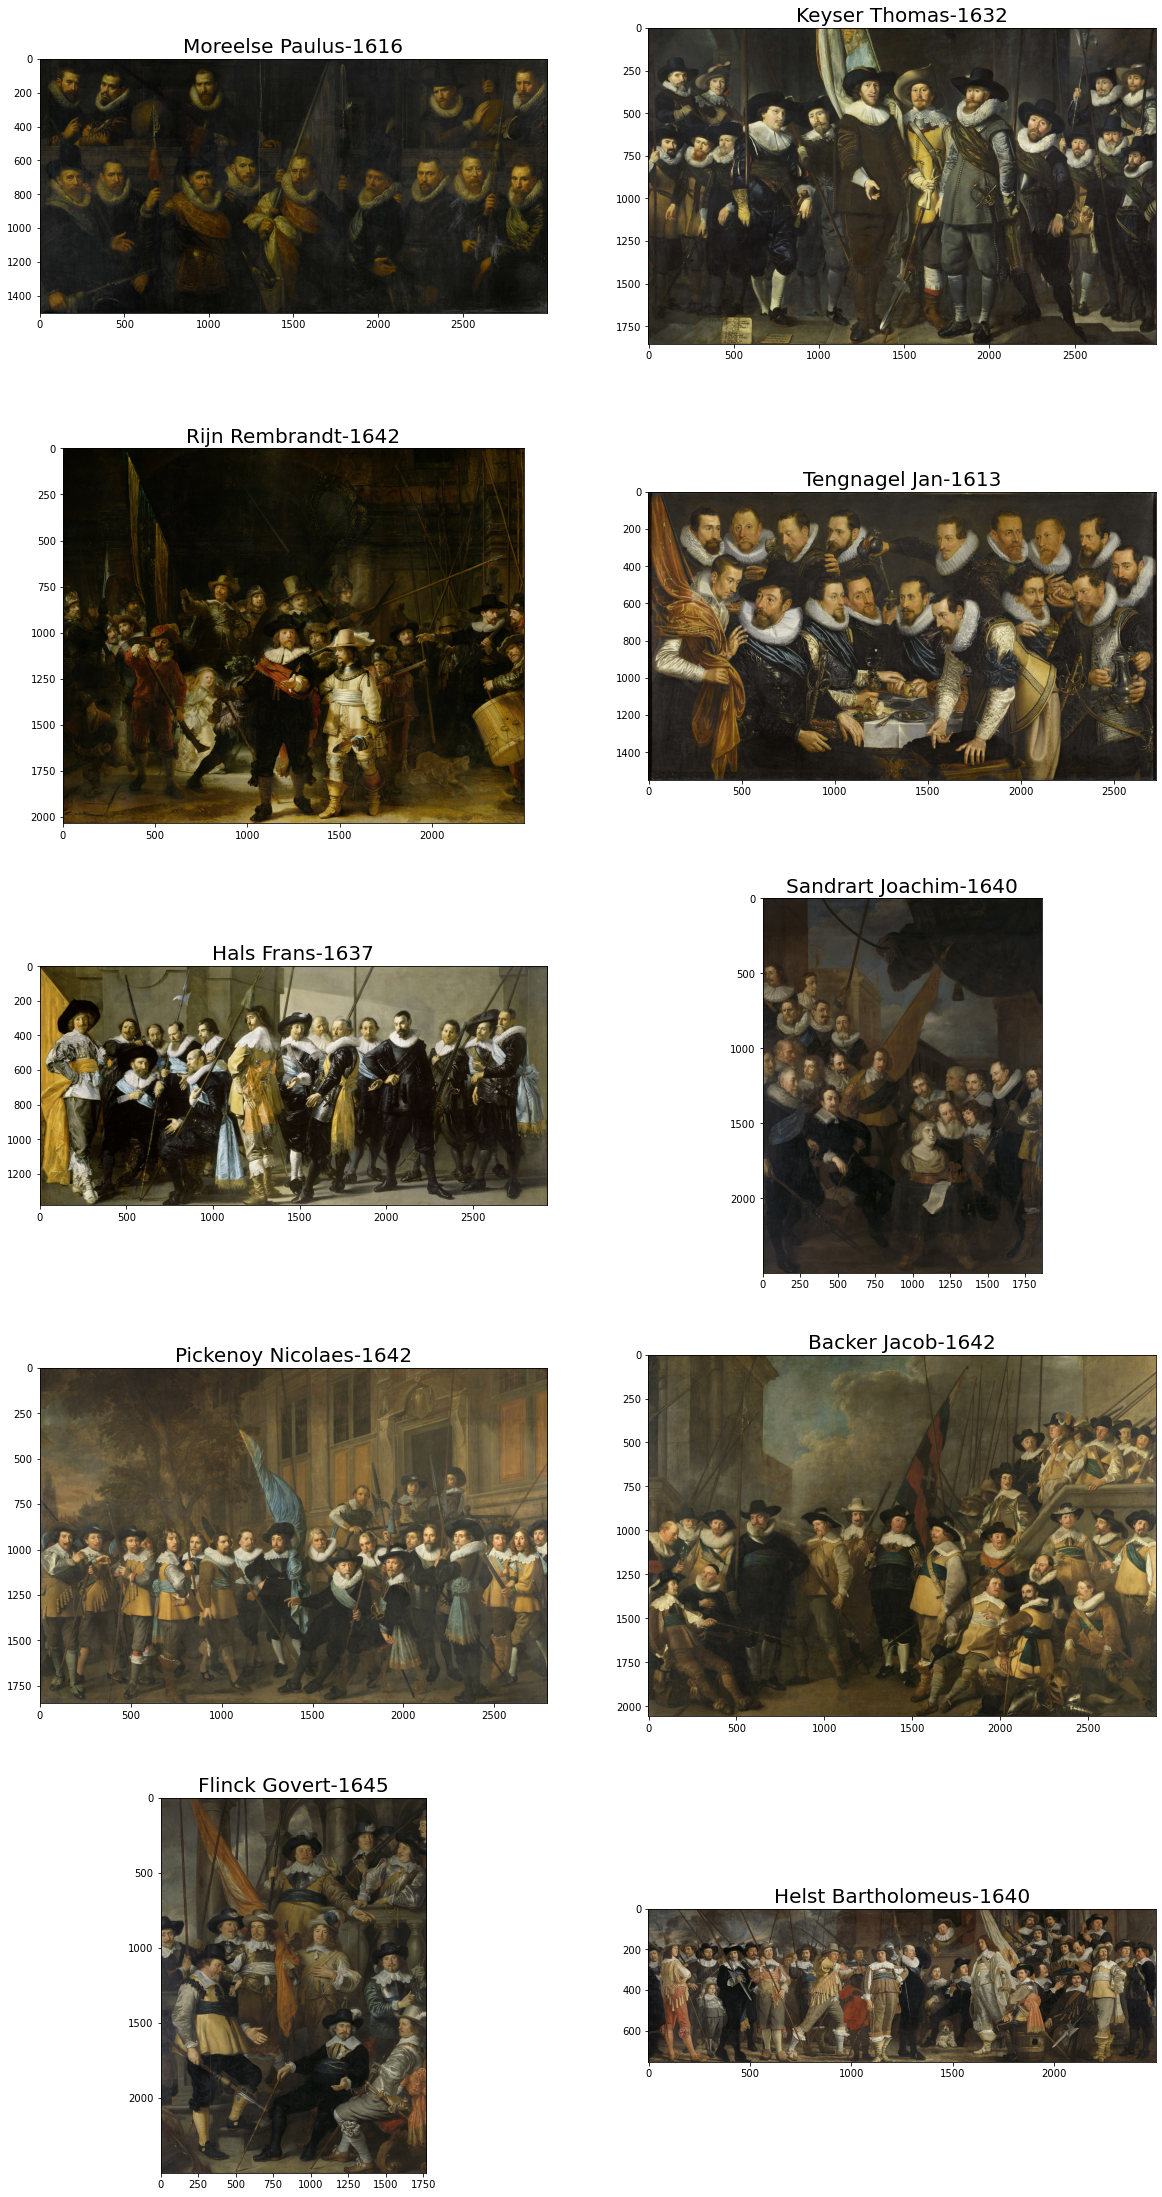

In [52]:
plt.figure() # Here we create a figure, which will be used for subploting of every single painting.
plt.figure(figsize=(20,40))
for n in range(10):
    artwork = paintings_list[n]
    plt.subplot(5,2,n + 1)
    plt.imshow(artwork)
    plt.title(painter_name[n] + '-' + year[n], fontsize=20)
    
plt.show()

In [51]:
edge_detection_karnel = np.array([ #Here we are loading edge detection karnel. 
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
]) / 9 

<Figure size 432x288 with 0 Axes>

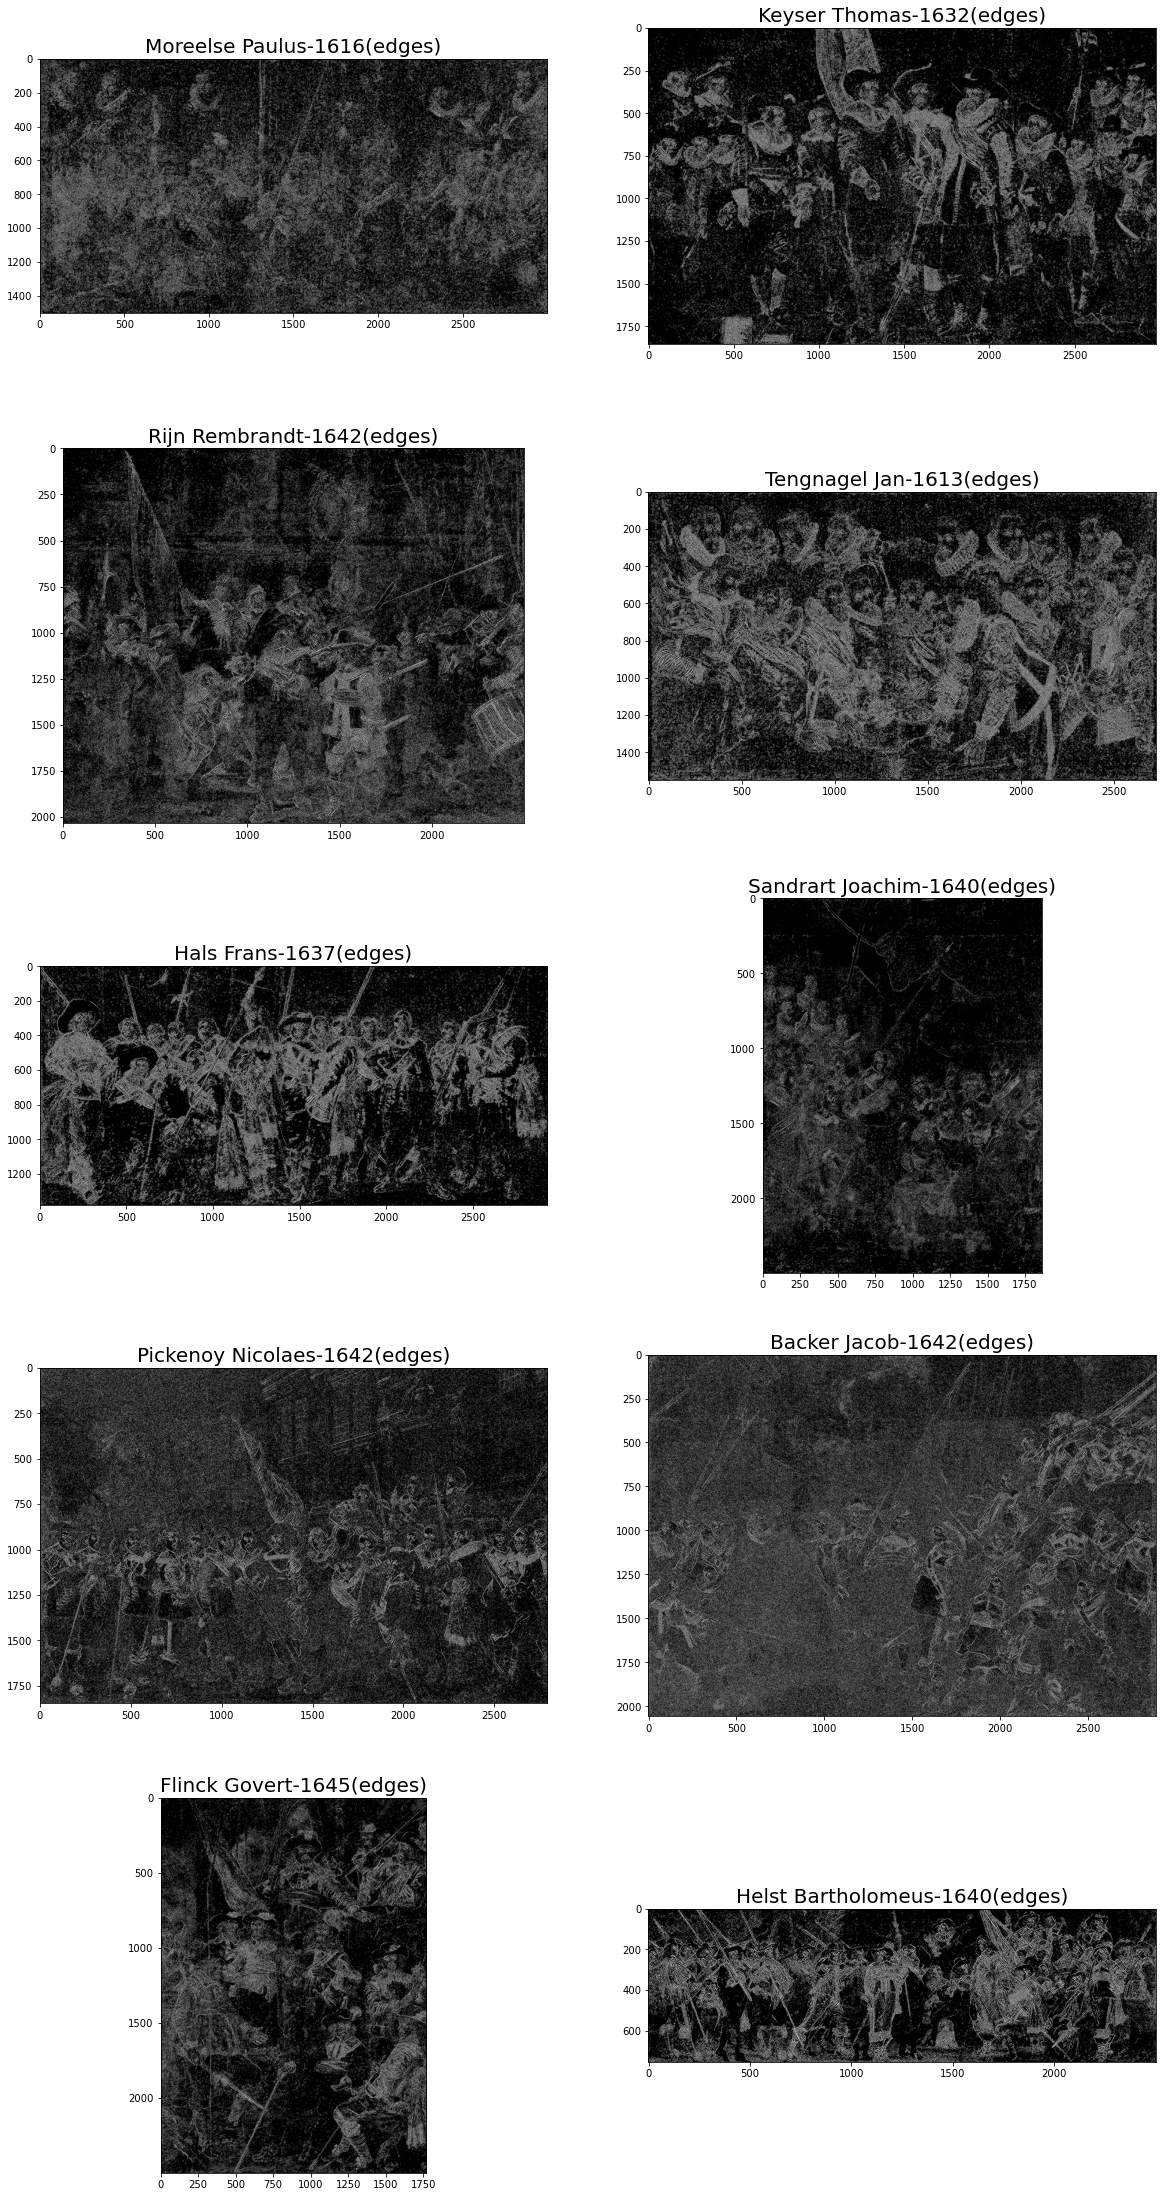

In [53]:
plt.figure() # Here we create a figure, which will be used for subploting. 
plt.figure(figsize=(20,40))
for n in range(10):
    artwork_gray = cv2.cvtColor(paintings_list[n], cv2.COLOR_BGR2GRAY)
    edge_detection = convolve(artwork_gray, edge_detection_karnel)
    plt.subplot(5,2,n + 1)
    plt.imshow(edge_detection, cmap='gray')
    plt.title(painter_name[n] + '-' + year[n] + '(edges)', fontsize=20)
    
plt.show()

# Conclusion : 
It is clear that the edges in Night Watch are very different compared to the other results. They are not structured, nor their traectory is pointing at a common angle. For that reason, we can approve the second hypothesis. 

# Bonus : 
The Smarthistory's short video for Rembrandt's Night Watch narrates the story and the different aspect of the painting, which makes it a masterpiece. Note that, the narrators mention our argument as well. 
(Source : https://www.youtube.com/watch?v=0D_rc92g27w)

# Proving the 3rd hypothesis:

In [54]:
box_blur = np.array([ # Here we are applying blox blur karnel. 
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]) / 9 

<Figure size 432x288 with 0 Axes>

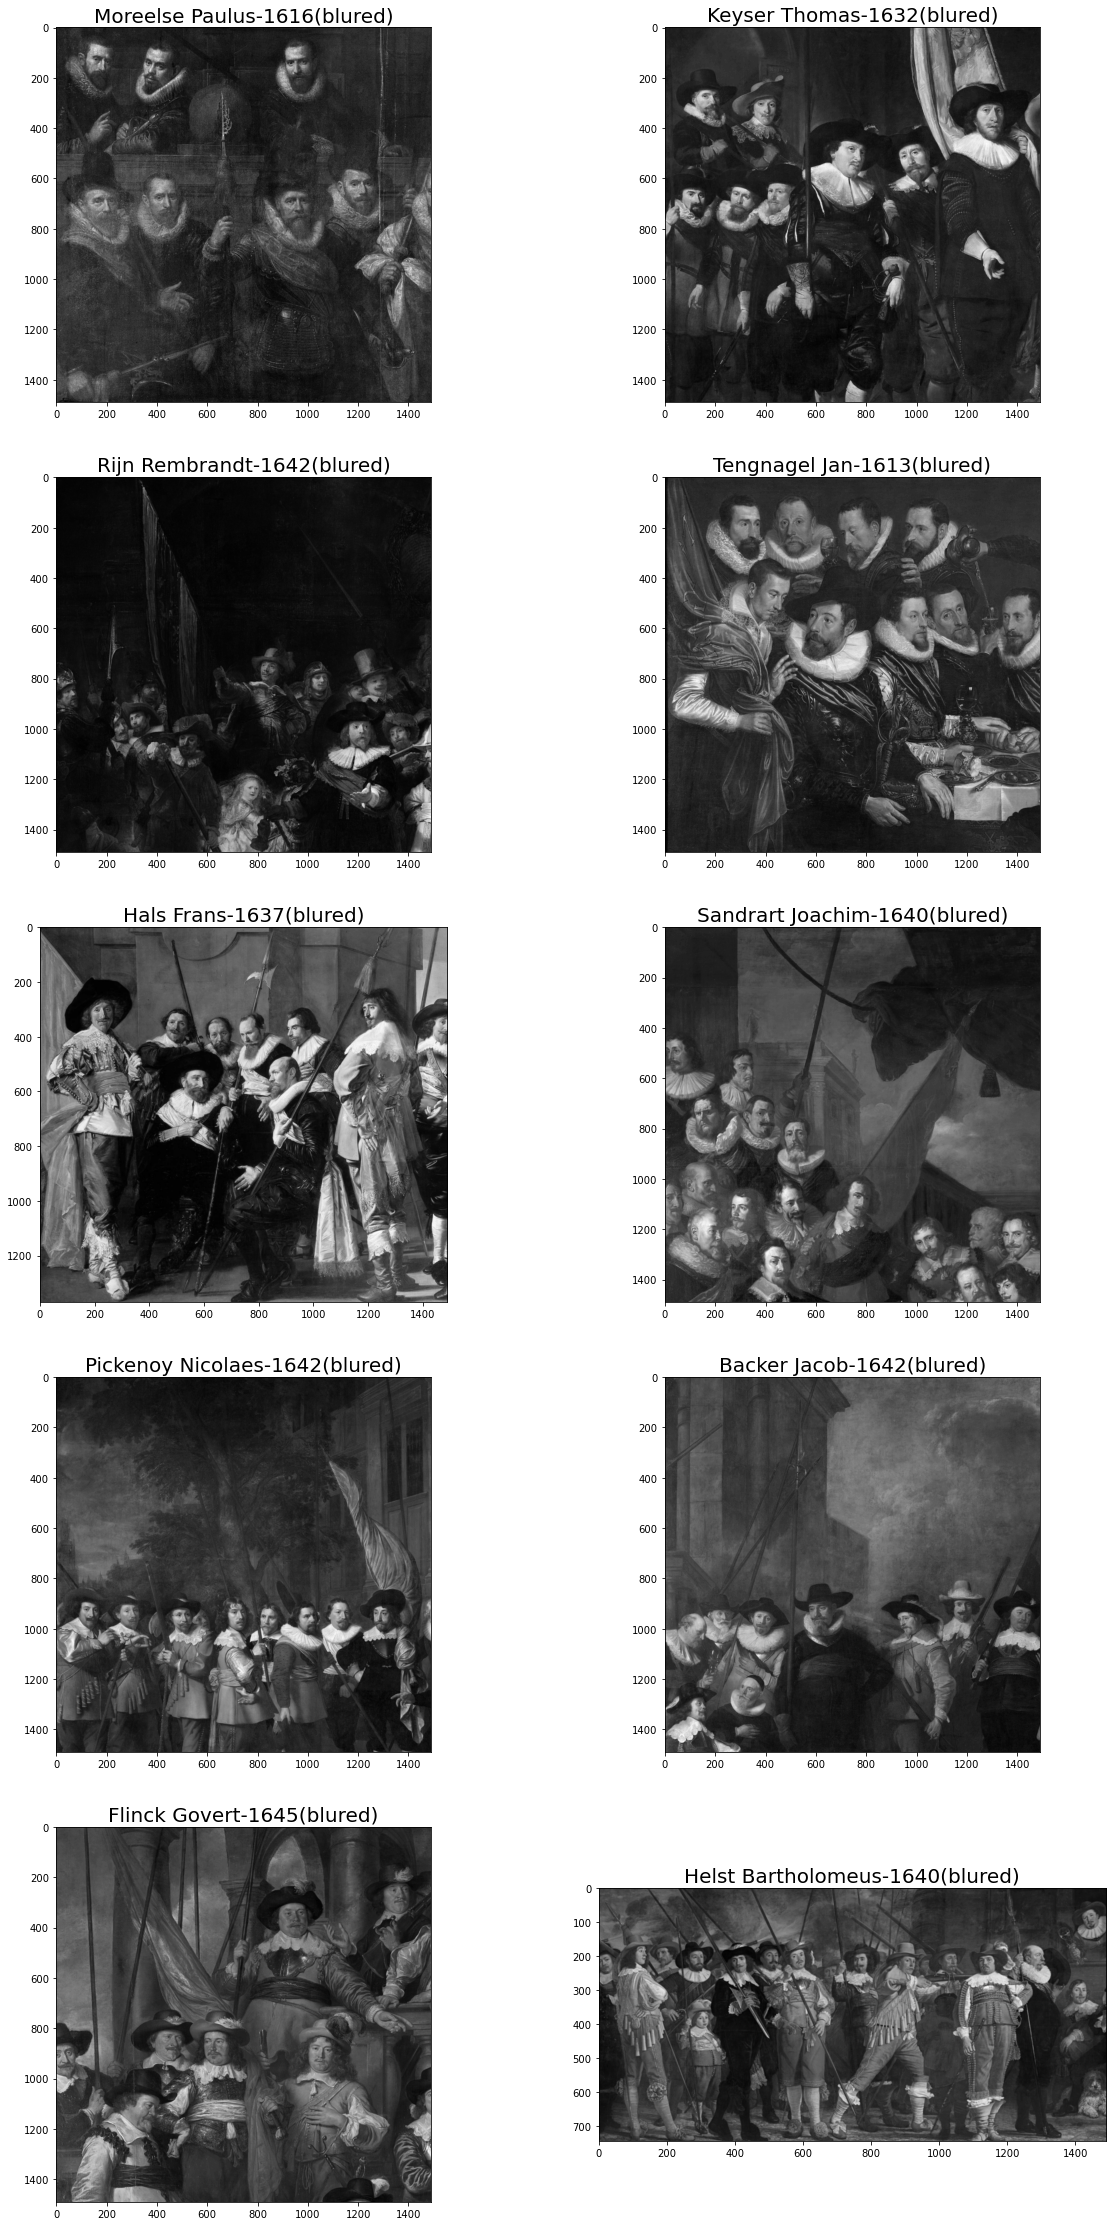

In [55]:
plt.figure() # Here we create a figure, which will be used for subploting. 
plt.figure(figsize=(20,40))
for n in range(10):
    artwork_gray = cv2.cvtColor(paintings_list[n], cv2.COLOR_BGR2GRAY)
    guassian_blur = convolve(artwork_gray, box_blur)
    plt.subplot(5,2,n + 1)
    plt.imshow(guassian_blur[10:1500, 10:1500], cmap='gray')
    plt.title(painter_name[n] + '-' + year[n] + '(blured)', fontsize=20)
    
plt.show()

# Conclusion : 
It is easily noting that the figures in Rembrand's paintings, are not positioned in a structured form. Also, in other examples is seen how even the people in the back have the same sharpeness on their faces as the figures in front of the group. Thus, after the applying of the karnel the blured elements become stronger and in the Night Watch, the people in the back are difficult for recognition this means the painter has try to blur them for a reason and his idea is to capture the distance from the viewer. Nowadays, we know the same technique in the use of the lenses in our cameras and their optical distance, known also as Bokeh effect in the photography. 

# Self - mark : 

In [16]:
self_mark = "" # This is an empty variable, which we are going to fill with our Introduction.
with open("text/project-info.txt", "r", encoding = "utf-8") as file: #The load file is loaded 
    self_mark = file.read() # The variable reads the text. 
print(self_mark) #Lets see it: 

# Data Science
## Final Exam Assessment Guidelines

## Project name:  The Genius of Rembrandt
## Project author:Dimitar Indzhov

### Terms and conditions:
* Use Jupyter notebook for text and maths. You can use any programming language you would like.
* Write your research and code in English. Bulgarian is also acceptable but try to use English.
* If you have sensitive, copyrighted, or copy-protected assets, including but not limited to, images, multimedia, code, documents, and datasets,
  you can sign an NDA (non-disclosure agreement) with the SoftUni team. Contact the lecturer if you need assistance with the process.
* Any code which does not comply with the Bulgarian law (as of the exam date), will be given zero points.
* Any malicious code, or code intended to do harm to the user's computer, information, or privacy, will be given zero points.

By submitting your project for the exam, you agree with these terms and conditions.

### Self-assessment:
The numbers in brackets define poss